### Sampling sentences for students (and others) to manually code as a validation dataset for:

- UD parsing
- speaker recognition

Copied from: linguistic_feature_extraction notebook.

### Resources:

- https://github.com/peter3125/enhanced-subject-verb-object-extraction (better than standard Spacy for subject-verb-object extraction)
- https://nbviewer.jupyter.org/gist/nealcaren/5105037 (how the Times writes about men and women)
- https://spacy.io/usage/linguistic-features
- https://stackoverflow.com/questions/40288323/what-do-spacys-part-of-speech-and-dependency-tags-mean

In [3]:
# TO_EXCLUDE = ['Mini Beasties', 'Ten in the Bed and Other Counting Rhymes', 'The Rescue Party', 'One Snowy Night', 'The Night Before Christmas', 'One Starry Night'] # Books that currently has issues in the excel file
TO_EXCLUDE = []

In [2]:
import os
import pdfplumber
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string
import spacy
from spacy import displacy
from spacy.lang.en.examples import sentences 

%matplotlib inline

In [2]:
nlp = spacy.load("en_core_web_lg")
#nlp.add_pipe(nlp.create_pipe('sentencizer'))
#nlp.add_pipe(nlp.create_pipe("parser"))

In [5]:
labels = pd.read_excel('./Book-List-Final-NONA.xlsx', sheet_name='Sheet1')
labels = labels.rename(columns={'Author ': 'Author'})
labels = labels.loc[~labels.Title.isin(TO_EXCLUDE)]

In [6]:
os.chdir('../text_pdfs')

In [7]:
df = pd.DataFrame()

def grab_text(title, labels):
    
    start = labels.loc[labels.Title==title]['Starting Page']
    if len(start)==0:
        print(title, "no start")
        start = 0
    else:
        start = start.values[0]
    end = labels.loc[labels.Title==title]['Ending Page']
    if len(end)==0:
        print(title, "no end")
        end = 0
    else:
        end = end.values[0]
    
    title = title + '.pdf'
    all_text = ''
    with pdfplumber.open(title) as pdf:
        for i, page in enumerate(pdf.pages):
            if i+1 >= start and i < end:
                single_page_text = page.extract_text()

                if single_page_text is not None:
                    all_text = all_text + '\n' + single_page_text
                
    return all_text

df['Title'] = [file.split('.')[0] for file in os.listdir() if file.split('.')[1]=='pdf']
df['Text'] = [grab_text(title, labels) for title in df.Title]

In [8]:
df.head()

,Title,Text
0,The Night Before Christmas,\n'Twas the night before Christmas\nwhen all t...
1,Sugarlump and the Unicorn,"\nThe unicorn has a silver horn, Her\neyes are..."
2,The Gruffalo,\nA mouse took a stroll through the deep dark ...
3,The Monstrous Tale of Celery Crumble,\nHave you met Celery Crumble?\nThat’s her rig...
4,Peace at Last,"\nThe hour was late.\nMr Bear was tired, Mrs B..."


In [9]:
df = df.loc[df.Text != ''].reset_index()

In [10]:
len(df)

196

### Converting the full dataset into a dataframe of sentences

#### Note: using strip() here to remove trailing or leading spaces for improved performance.

In [14]:
# Method:
# get all sentences in all texts, and their length in words
# select top 20 longest sentences
# output to file
# select top 20 shortest sentences
# output to file
# select random sample of 15% of sentences
# output to file

In [83]:
sentences = pd.DataFrame()

book_col = []
sentences_col = []
length_col = []
index_col = []

for title, text in zip(df.Title, df.Text):
    text = text.replace('\n', ' ') # This is only safe provided the line break is not being used to separate sentences w/o puntctuation...
    text = text.replace('\t', ' ') # This allows us to save as tsv (and simplifies the whitespace)
    text = ' '.join(text.split())
    
    
    doc = nlp(text)
    sentence_list = list(doc.sents)
    
    for si, sen in enumerate(sentence_list):
        book_col.append(title)
        
        doc = sen #nlp(sen.text.strip())
        sentences_col.append(doc)
        length_col.append(len(doc.text.translate(str.maketrans('', '', string.punctuation)).split(' ')))
        index_col.append(si)

    
sentences['book'] = book_col
sentences['sentence_length'] = length_col
sentences['sentence'] = sentences_col
sentences['sentence_index'] = index_col

In [84]:
sentences

,book,sentence_length,sentence,sentence_index
0,The Night Before Christmas,19,"(', Twas, the, night, before, Christmas, when,...",0
1,The Night Before Christmas,18,"(The, stockings, were, hung, by, the, chimney,...",1
2,The Night Before Christmas,17,"(The, children, were, nestled, all, snug, in, ...",2
3,The Night Before Christmas,1,"(as&ij-, ”)",3
4,The Night Before Christmas,41,"(And, mamma, in, her, kerchief, ,, and, I, in,...",4
...,...,...,...,...
14161,Little Monkey,9,"(“, And, very, lucky, !, ”, said, the, rest, o...",42
14162,Little Monkey,6,"(Little, Monkey, knew, they, were, right, .)",43
14163,Little Monkey,11,"(Because, the, smaller, you, are, ,, the, larg...",44
14164,Little Monkey,7,"(But, best, of, all, ., ., .)",45


In [85]:
sentences.loc[0].sentence

'Twas the night before Christmas when all through the house Not a creature was stirring, not even a mouse.

In [86]:
sentence_lenghts = sentences.groupby('sentence_length').agg({'book': 'count'}).rename(columns={'book': 'count'})

In [87]:
sentence_lenghts.head(50)

,count
sentence_length,
1,550
2,803
3,963
4,1269
5,1246
6,1224
7,1189
8,1036
9,936


In [88]:
sentences.loc[4900].sentence

Sometimes the sun was so blinding, I could barely see where I was going.

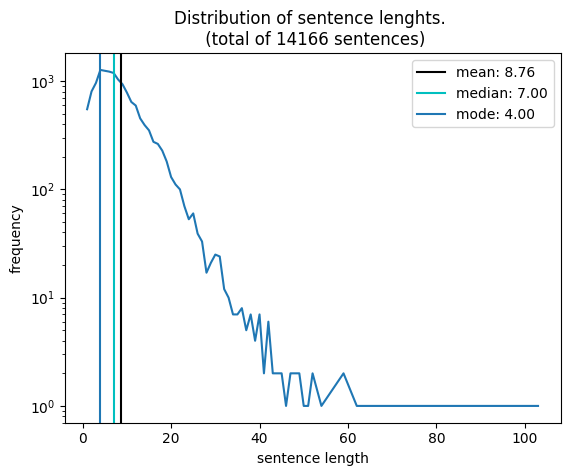

In [89]:
plt.plot(sentence_lenghts.index, sentence_lenghts['count'])
plt.axvline(np.mean(sentences.sentence_length), label='mean: %.2f' % np.mean(sentences.sentence_length), color='k')
plt.axvline(np.median(sentences.sentence_length), label='median: %.2f' % np.median(sentences.sentence_length), color='c')

mode = 4
plt.axvline(mode, label='mode: %.2f' % mode)

plt.title('Distribution of sentence lenghts. \n (total of %d sentences)' % len(sentences))
plt.xlabel('sentence length')
plt.ylabel('frequency')
plt.yscale('log')
plt.legend();

In [97]:
coding_sample = sentences.sample(frac=0.15, axis=0, random_state=42)

In [91]:
coding_sample

,book,sentence_length,sentence,sentence_index
12493,What The Ladybird Heard Next,22,"(Now, the, fat, red, hen, with, her, thin, bro...",1
1350,The Enormous Crocodile,11,"("", I, have, secret, plans, and, clever, trick...",83
3656,Gordon's Great Escape,11,"(She, took, him, to, the, park, to, play, on, ...",13
11731,Jesus' Christmas Party,1,"(“, There, .)",10
4560,Sir Charlie Stinky Socks and the Really Big Ad...,21,"(Inside, the, tower, a, windy, ,, windy, stair...",2
...,...,...,...,...
3784,Dogger,9,"(Dogger, had, just, been, bought, by, a, littl...",86
3076,Whatever Next!,25,"(He, found, a, space, helmet, on, the, drainin...",5
7799,Ravi's Roar,4,"(Even, Biscuits, the, dog, !)",2
12890,The Gruffalo's Child,4,"(“, You, ’re, not, the, Mouse, ., ”)",25


In [92]:
coding_lenghts = coding_sample.groupby('sentence_length').agg({'book': 'count'}).rename(columns={'book': 'count'})

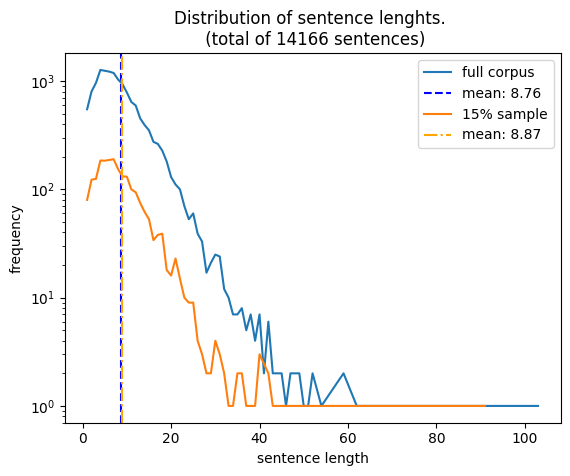

In [93]:
plt.plot(sentence_lenghts.index, sentence_lenghts['count'], label='full corpus')
plt.axvline(np.mean(sentences.sentence_length), label='mean: %.2f' % np.mean(sentences.sentence_length), color='b', linestyle='--')
# plt.axvline(np.median(sentences.sentence_length), label='median: %.2f' % np.median(sentences.sentence_length), color='c')

# mode = 4
# plt.axvline(mode, label='mode: %.2f' % mode)

plt.plot(coding_lenghts.index, coding_lenghts['count'], label='15% sample')
plt.axvline(np.mean(coding_sample.sentence_length), label='mean: %.2f' % np.mean(coding_sample.sentence_length), color='orange', linestyle='-.')


plt.title('Distribution of sentence lenghts. \n (total of %d sentences)' % len(sentences))
plt.xlabel('sentence length')
plt.ylabel('frequency')
plt.yscale('log')
plt.legend();

In [94]:
os.chdir('../code_new_version/')

In [98]:
coding_sample.to_csv('./sentences_for_coding/sample_15pc.csv', sep="\t")

In [96]:
sentences.to_csv('./sentences_for_coding/all_sentences.csv', sep="\t")

In [168]:
sentences = sentences.sort_values('sentence_length')

In [194]:
for i in range(10):
    row = sentences.reset_index().loc[12412 - i]
    doc = row.sentence
    sentences_examples = add_example_sentence(doc, 'long', 'long_%d' % i, row.book, sentences_examples, row.sentence_length)

In [198]:
l = 10
these_sentences = sentences.loc[sentences.sentence_length==l].sample(frac=1)

for i in range(10):
    row = these_sentences.iloc[i]
    doc = row.sentence
    sentences_examples = add_example_sentence(doc, str(l), 'len%d_%d' % (l, i), row.book, sentences_examples, row.sentence_length)

In [199]:
sentences_examples.to_csv('../code/example_spacy_sentences/details.csv')